In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 10)
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from scipy.sparse import hstack
import seaborn as sns
import time
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.applications import NASNetLarge
import PIL
from PIL import ImageOps, ImageFilter

input_path = '/kaggle/input/sf-dst-car-price-prediction-part2/'
tf.__version__

'2.6.2'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12220719420352588883
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14111498824974066749
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2021-12-18 15:24:49.349336: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 15:24:49.403261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 15:24:49.499511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 15:24:49.500272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [3]:
!nvidia-smi

Sat Dec 18 15:25:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## EDA

In [6]:
df = pd.read_csv(input_path + 'train.csv')
df['sample'] = 1
test = pd.read_csv(input_path + 'test.csv')
test['price'] = 0
test['sample'] = 0
data = test.append(df, sort=False).reset_index(drop=True)
data['log_price'] = np.log(data.price)
data['filename'] = data['sell_id'].apply(lambda x: str(x) + '.jpg')
data['train'] = np.random.uniform(size = data.shape[0])
data['train'] = data['train'].apply(lambda x: 1 if x > 0.3 else 0)
print(df.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 26)


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Пример картинок (random sample)


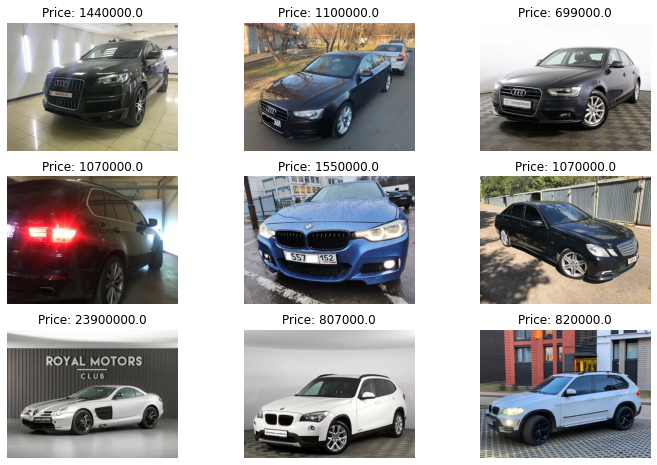

In [9]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = data[data['sample'] == 1].sample(n=9)
random_image_id = random_image['sell_id'].values
random_image_price = random_image['price'].values

for index, id in enumerate(random_image_id):
    im = PIL.Image.open(input_path + 'img/img/' + str(id) + '.jpg')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Price: '+str(random_image_price[index]))
    plt.axis('off')
plt.show()

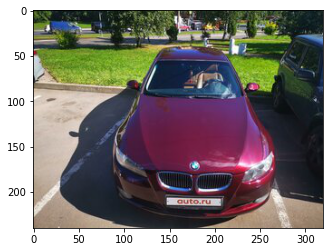

(320, 240)

In [8]:
image = PIL.Image.open(input_path + 'img/img/1100195294.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## CV

In [43]:
RANDOM_SEED = 42
IMG_SIZE = 331
BATCH_SIZE = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     rotation_range = 10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=0.3,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe( 
    dataframe=data[(data['sample'] == 1) & (data['train'] == 1)],
    directory=input_path + 'img/img/',
    x_col='filename',
    y_col='log_price',
    shuffle=False,
    class_mode='raw',
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

valid_generator = train_datagen.flow_from_dataframe( 
    dataframe=data[(data['sample'] == 1) & (data['train'] == 0)],
    directory=input_path + 'img/img/',
    x_col='filename',
    y_col='log_price',
    shuffle=False,
    class_mode='raw',
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

test_generator = test_datagen.flow_from_dataframe( 
    dataframe=data,
    directory=input_path + 'img/img/',
    x_col='filename',
    y_col='log_price',
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 4678 validated image filenames.
Found 2004 validated image filenames.
Found 8353 validated image filenames.


In [19]:
base_model = NASNetLarge(weights='imagenet', include_top=False)

In [33]:
# Устанавливаем новую голову

x = base_model.output
base_model.trainable = False
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
# x = Dropout(0.25)(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="mse", optimizer=optimizers.Adam(lr=1e-4), metrics=["mape"]) #learning_rate=LR

In [34]:
base_model.trainable

False

In [35]:
history = model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = 10,
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_mape',patience=2,verbose=1,restore_best_weights=True)]
)

Epoch 1/10
468/468 [==============================] - 156s 301ms/step - loss: 3.6438 - mape: 5.8296 - val_loss: 0.2707 - val_mape: 2.8455
Epoch 2/10
468/468 [==============================] - 136s 290ms/step - loss: 0.1882 - mape: 2.3530 - val_loss: 0.2502 - val_mape: 2.7558
Epoch 3/10
468/468 [==============================] - 136s 290ms/step - loss: 0.1584 - mape: 2.1443 - val_loss: 0.2086 - val_mape: 2.4943
Epoch 4/10
468/468 [==============================] - 135s 290ms/step - loss: 0.1519 - mape: 2.1265 - val_loss: 0.2120 - val_mape: 2.5059
Epoch 5/10
468/468 [==============================] - 135s 289ms/step - loss: 0.1479 - mape: 2.1065 - val_loss: 0.1988 - val_mape: 2.3830
Epoch 6/10
468/468 [==============================] - 136s 290ms/step - loss: 0.1422 - mape: 2.0662 - val_loss: 0.1943 - val_mape: 2.3430
Epoch 7/10
468/468 [==============================] - 135s 290ms/step - loss: 0.1411 - mape: 2.0944 - val_loss: 0.1867 - val_mape: 2.3118
Epoch 8/10
468/468 [==============

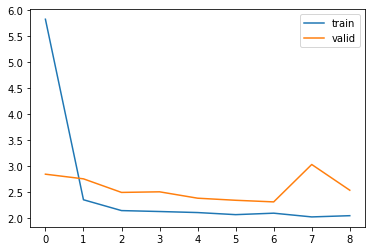

In [36]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.legend(['train','valid']);

In [37]:
model.save('../working/CV_model.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [44]:
x = model.predict(test_generator)

In [49]:
data['CV_prediction'] = x.reshape(-1)

In [57]:
print('Train MAPE:',mape(np.exp(data[(data['sample'] == 1) & (data['train'] == 1)]['log_price']), np.exp(data[(data['sample'] == 1) & (data['train'] == 1)]['CV_prediction'])))
print('Valid MAPE:',mape(np.exp(data[(data['sample'] == 1) & (data['train'] == 0)]['log_price']), np.exp(data[(data['sample'] == 1) & (data['train'] == 0)]['CV_prediction'])))

Train MAPE: 26.546939747823327
Valid MAPE: 35.24359164944226


In [59]:
data.to_csv('../working/CV_model_predictions.csv', index = False)